R0: t = -4.834, p = 0.004741
tau: t = -14.092, p = 0.0000


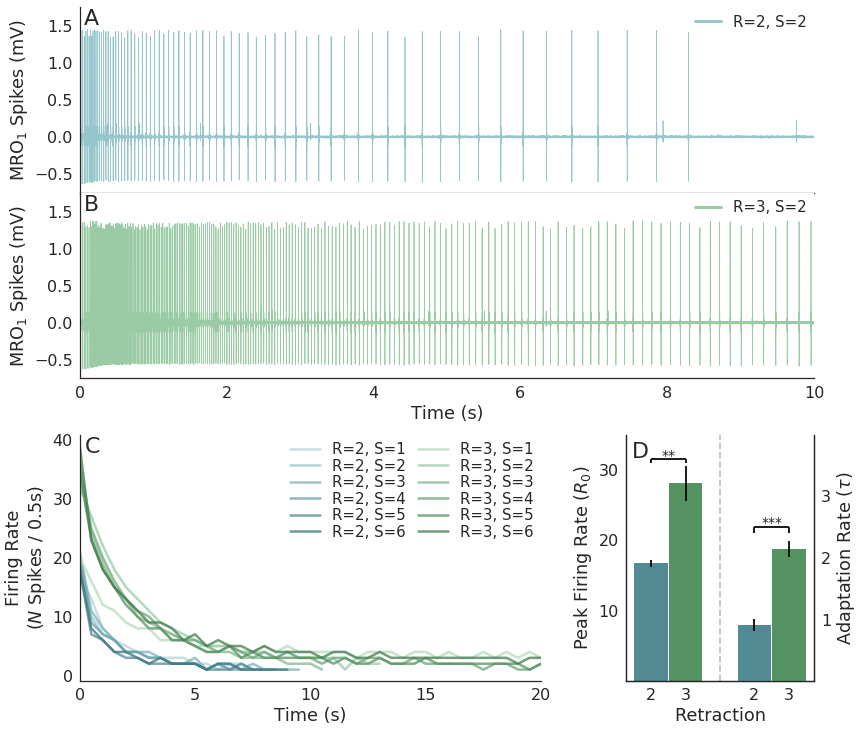

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import read_csv
from scipy.stats import ttest_rel
sns.set_style('white')
sns.set_context('notebook', font_scale=1.6)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot extracellular data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,12))

## Initialize canvas for raw trace plots.
gs = gridspec.GridSpec(2, 1)
gs.update(left=0.1, right=0.95, bottom=0.45, hspace=0.00)

## Initialize colors.
palettes = np.vstack([sns.cubehelix_palette(6, start=2.5, rot=0, dark=0.4, light=.8).as_hex(),
                      sns.cubehelix_palette(6, start=2, rot=0, dark=0.4, light=.8).as_hex()])

for n, r, s, panel in zip(range(2), [2, 3], [2, 2], ['A', 'B']):
    
    ## Load data.
    npz = np.load('raw/stretch_r%ss%s.npz' %(r, s))
    data = npz['data']
    times = npz['times']
    
    ## Plot.
    ax = plt.subplot(gs[n, 0])
    ax.plot(times, data * 1e3, color=palettes[n,1], linewidth=0.75)
    ax.set(xlim=(0, 10), xlabel='Time (s)', ylabel=r'MRO$_1$ Spikes (mV)', ylim=(-0.75, 1.75))
    if not n: ax.set(xticks=[], xlabel='')
    ax.text(0.05, 1.725, panel, ha='left', va='top', fontsize=22)
    sns.despine(ax=ax)
    
    ax.plot([], [], lw=3, color=palettes[n,1], label='R=%0.0f, S=%0.0f' %(r,s))
    ax.legend(loc=0, fontsize=15, borderpad=0, handlelength=1.75)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot spike rates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
       
## Initialize canvas for spike rates and parameters.
gs = gridspec.GridSpec(1, 3)
gs.update(left=0.1, right=0.95, top=0.385, bottom=0.1, hspace=0.0, wspace=0.45)

## Plot histogram of spike magnitudes.
ax = plt.subplot(gs[:, :2])
    
## Load spike rate data.
data = read_csv('spike_rates.csv')
        
for i, r in enumerate(data.Retraction.unique()):
        
    for j, s in enumerate(data.Speed.unique()):

        ## Extract data.
        t, y = data.loc[np.logical_and(data.Retraction==r, data.Speed==s),['Time','Rate']].T.as_matrix()
        
        ## Plot.
        color = palettes[i,j]
        ax.plot(t, y, lw=2.5, alpha=0.75, color=color, label='R=%0.0f, S=%0.0f' %(r,s))

ax.set(xlim=(0,20), xticks=np.arange(0,21,5), xlabel='Time (s)', ylabel='Firing Rate\n'+r'($N$ Spikes / 0.5s)')
ax.legend(ncol=2, fontsize=15, borderpad=0, labelspacing=0.1, columnspacing=0.8)
ax.text(0.2, 40.5, 'C', ha='left', va='top', fontsize=22)
sns.despine(ax=ax)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare data.
data = read_csv('exponential_curve.csv')
data = data.melt(id_vars=('Retraction','Speed'), var_name='Parameter', value_name='Value')
gb = data.groupby(['Parameter','Retraction']).Value

## Plot peak firing.
mu = gb.mean()[r'$R_0$']
sd = gb.std()[r'$R_0$']
se = sd / np.sqrt( data.Speed.unique().shape[0] )

t, p = ttest_rel(data.loc[np.logical_and(data.Parameter==r'$R_0$', data.Retraction==2), 'Value'],
          data.loc[np.logical_and(data.Parameter==r'$R_0$', data.Retraction==3), 'Value'])
print('R0: t = %0.3f, p = %0.6f' %(t,p))

ax = plt.subplot(gs[:, -1])
ax.bar([0,1], mu, 0.975, yerr=se, color=palettes[:,-2])
ax.set(xticks=[0, 1, 3, 4], xticklabels=[2, 3, 2, 3], xlabel='Retraction', 
       ylim=(0,35), yticks=[10, 20, 30], ylabel=r'Peak Firing Rate ($R_0$)')
ax.spines['top'].set_visible(False)
ax.text(-0.55, 34, 'D', ha='left', va='top', fontsize=22)

ax.hlines(31.5, 0,1)
ax.vlines([0,1], 31, 31.5)
ax.text(0.5, 31.5, '**', ha='center', fontsize=14)

## Plot decay.
mu = gb.mean()[r'$\tau$']
sd = gb.std()[r'$\tau$']
se = sd / np.sqrt( data.Speed.unique().shape[0] )

t, p = ttest_rel(data.loc[np.logical_and(data.Parameter==r'$\tau$', data.Retraction==2), 'Value'],
          data.loc[np.logical_and(data.Parameter==r'$\tau$', data.Retraction==3), 'Value'])
print('tau: t = %0.3f, p = %0.4f' %(t,p))

ax = ax.twinx()
ax.bar([3,4], mu, 0.975, yerr=se, color=palettes[:,-2])
ax.vlines(2,0,4,linestyle='--',alpha=0.25)
ax.set(ylim=(0,4), yticks=[1, 2, 3], ylabel=r'Adaptation Rate ($\tau$)')
ax.spines['top'].set_visible(False)

ax.hlines(2.5, 3, 4)
ax.vlines([3,4], 2.4, 2.5)
ax.text(3.5, 2.5, '***' %t, ha='center', fontsize=14)

plt.savefig('sensory_figure.png', dpi=300)